<a href="https://www.kaggle.com/code/asad1212/100-sports-image-classification?scriptVersionId=204433173" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

## Plotting Image

In [3]:
def display_images(loader, class_names, num_images=100):
    images_shown = 0
    plt.figure(figsize=(20, 20))
    
    for inputs, labels in loader:
        batch_size = inputs.size(0)
        
        for i in range(batch_size):
            if images_shown >= num_images:
                plt.show()  # Display the figure when we've collected enough images
                return
            
            image = inputs[i]
            label = labels[i].item()  # Get the label index
            image = image.permute(1, 2, 0)  # Rearrange dimensions for display (C, H, W) -> (H, W, C)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
            
            plt.subplot(10, 10, images_shown + 1)  # Display in a 10x10 grid
            plt.imshow(image.clip(0, 1))  # Clip to valid range
            plt.title(class_names[label])
            plt.axis('off')
            
            images_shown += 1

## Plot Results

In [52]:
def show_results(results):
    train_acc, train_loss, val_acc, val_loss = results
    
    # Plot losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.show()
    

## Set Device

Set the device to GPU if available, otherwise use CPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Dataset

### 1. Paths

In [5]:
train_path = '/kaggle/input/sports-classification/train'
test_path = '/kaggle/input/sports-classification/test'
val_path = '/kaggle/input/sports-classification/valid'

### 2. Transformation
       Make the data right for the model.

In [42]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### 3. Load Train, Val and Test Data

In [43]:
train_data = ImageFolder(root = train_path, transform = train_transforms)
val_data = ImageFolder(root = val_path, transform = val_transforms)
test_data = ImageFolder(root = test_path, transform = val_transforms)

### 4. Create DataLoaders

In [44]:
train_loader = DataLoader(dataset = train_data, batch_size = 32, shuffle = True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset = val_data, batch_size = 32, shuffle = False, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size = 32, shuffle = False, num_workers=4, pin_memory=True)

### 5. See Number Of Classes

In [9]:
num_classes = len(train_data.classes)
print('Total Number of classes in Dataset :', num_classes)

Total Number of classes in Dataset : 100


### 6. Plot Some of the classes

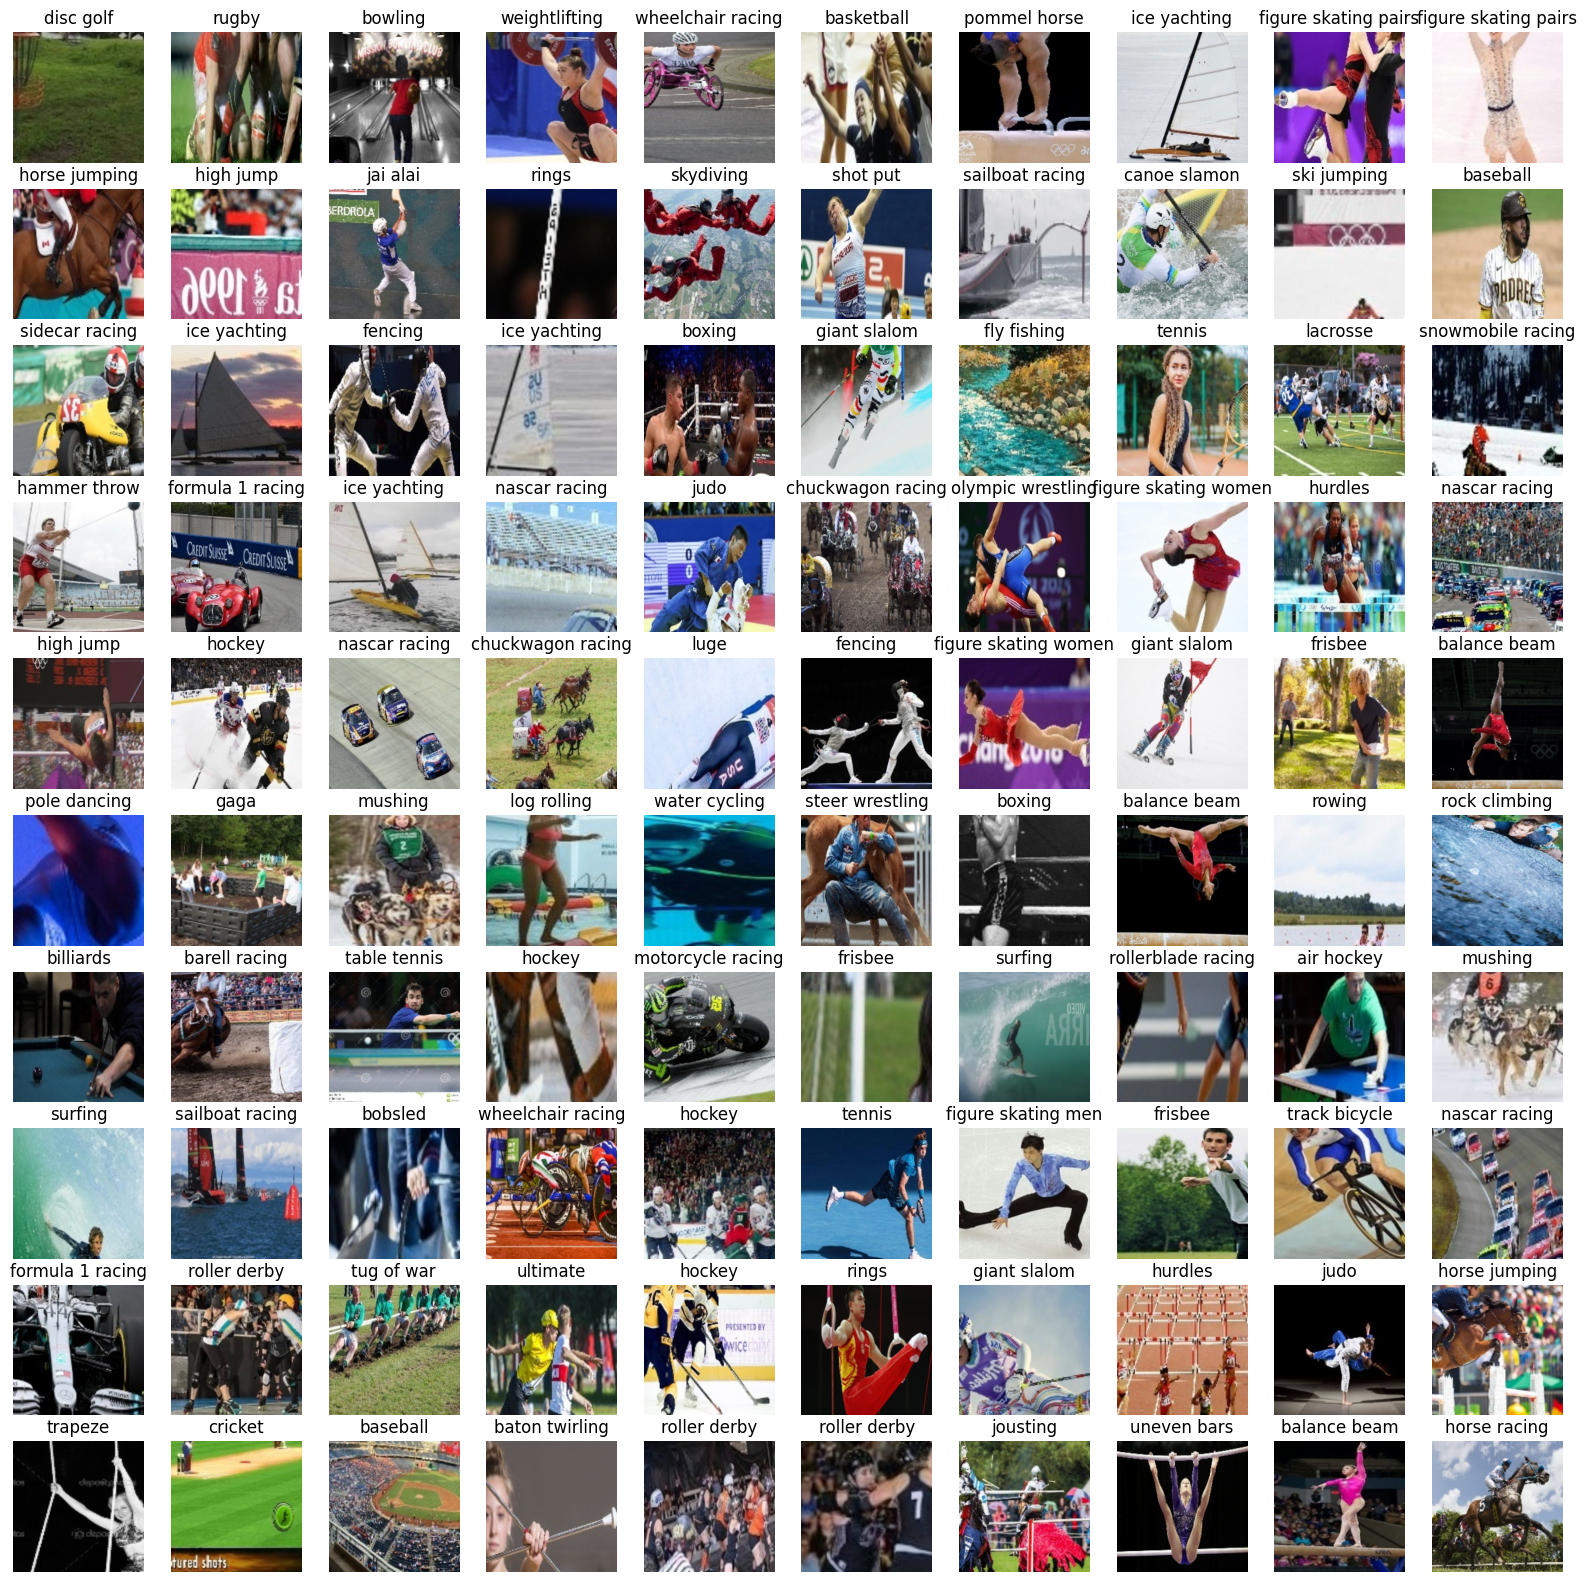

In [15]:
display_images(train_loader, train_data.classes)

## Trainig Loop

In [16]:
def train_loop(n_epochs, model, optimizer, criterion, train_loader, scheduler = None):
    import datetime
    val_losses = []
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        if scheduler:
            scheduler.step()
            
            
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_predictions / total_predictions
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for validation
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct_predictions / val_total_predictions
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{n_epochs}], '+
              f'Train_Loss: {train_loss:.3f}, ' +
              f'Train_Accuracy: {train_accuracy:.2f}, '+
              f'Val_Loss: {val_loss:.3f}, '+
              f'Val_Accuracy: {val_accuracy}')
    return [train_accuracies, train_losses, val_accuracies, val_losses]

## Validation Loop

In [17]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

# AlexNet

Load AlexNet as pre-trained model

In [31]:
model = models.alexnet(weights = models.AlexNet_Weights.DEFAULT)

## Modifiy last layer of the model

In order to implement transfer learning we need to modeify the last layer of the AlexNet. So instead of 1000 classes we have 100 classes, now modify for it.

In [32]:
num_classes = len(train_data.classes)
for param in model.features.parameters():
    param.requires_grad = False
# for parm in model.features[-3].parameters():
#     param.requires_grad = True
    
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

## Send Model to device

In [33]:
model = model.to(device = device)

## Define Loss Function and Optimizer

In [34]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

## Train the model

In [35]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 2.190, Train_Accuracy: 44.48, Val_Loss: 0.824, Val_Accuracy: 78.4
Epoch [2/15], Train_Loss: 1.406, Train_Accuracy: 61.04, Val_Loss: 0.696, Val_Accuracy: 80.4
Epoch [3/15], Train_Loss: 1.212, Train_Accuracy: 65.95, Val_Loss: 0.565, Val_Accuracy: 83.4
Epoch [4/15], Train_Loss: 1.077, Train_Accuracy: 69.64, Val_Loss: 0.514, Val_Accuracy: 85.0
Epoch [5/15], Train_Loss: 1.036, Train_Accuracy: 70.75, Val_Loss: 0.556, Val_Accuracy: 83.2
Epoch [6/15], Train_Loss: 0.862, Train_Accuracy: 75.60, Val_Loss: 0.469, Val_Accuracy: 85.0
Epoch [7/15], Train_Loss: 0.814, Train_Accuracy: 76.55, Val_Loss: 0.439, Val_Accuracy: 86.8
Epoch [8/15], Train_Loss: 0.789, Train_Accuracy: 78.13, Val_Loss: 0.432, Val_Accuracy: 86.0
Epoch [9/15], Train_Loss: 0.762, Train_Accuracy: 78.16, Val_Loss: 0.422, Val_Accuracy: 88.0
Epoch [10/15], Train_Loss: 0.731, Train_Accuracy: 79.37, Val_Loss: 0.410, Val_Accuracy: 87.8
Epoch [11/15], Train_Loss: 0.720, Train_Accuracy: 79.52, Val_Loss: 0.411, Val_A

## Plot the Graphs

In [36]:
train_accuracies, train_losses, val_accuracies, val_losses = history

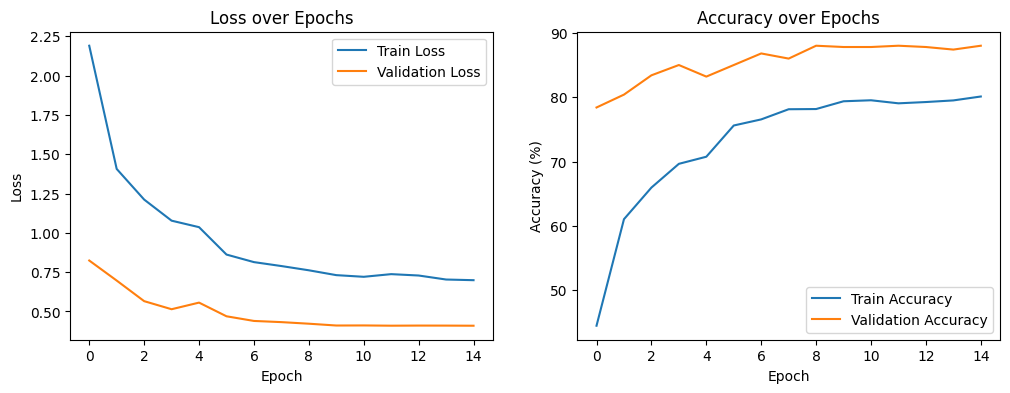

In [37]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy over Epochs")

plt.show()

## Validate the model

In [38]:
import collections
all_acc_dict = collections.OrderedDict()

all_acc_dict['AlexNet'] = validate(model, train_loader, val_loader)

Accuracy train: 0.85
Accuracy val: 0.88


# VGGNET

## VGG16

Load VGG16 as pre-trained model

In [40]:
model = models.vgg16(weights = models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s]  


## Modify Last Layer of the model

In [41]:
for param in model.parameters():
    param.requires_grad = False
    
    
# for param in model.classifier[-2].parameters():
#     param.requires_grad = True

# for param in model.features[-10:].parameters():  # Last two convolutional layers
#     param.requires_grad = True
    
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

## Send Model to device

In [42]:
model = model.to(device)
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

Using 2 GPUs


## Define Loss Function and Optimization

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

## Train the model

In [44]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/15], Train_Loss: 2.782, Train_Accuracy: 40.65, Val_Loss: 1.397, Val_Accuracy: 77.4
Epoch [2/15], Train_Loss: 1.638, Train_Accuracy: 63.33, Val_Loss: 0.924, Val_Accuracy: 83.0
Epoch [3/15], Train_Loss: 1.319, Train_Accuracy: 68.49, Val_Loss: 0.729, Val_Accuracy: 84.2
Epoch [4/15], Train_Loss: 1.186, Train_Accuracy: 70.22, Val_Loss: 0.628, Val_Accuracy: 85.4
Epoch [5/15], Train_Loss: 1.103, Train_Accuracy: 71.66, Val_Loss: 0.552, Val_Accuracy: 87.8
Epoch [6/15], Train_Loss: 1.049, Train_Accuracy: 72.75, Val_Loss: 0.545, Val_Accuracy: 88.0
Epoch [7/15], Train_Loss: 1.035, Train_Accuracy: 73.12, Val_Loss: 0.540, Val_Accuracy: 87.8
Epoch [8/15], Train_Loss: 1.027, Train_Accuracy: 72.83, Val_Loss: 0.535, Val_Accuracy: 87.6
Epoch [9/15], Train_Loss: 1.038, Train_Accuracy: 73.30, Val_Loss: 0.530, Val_Accuracy: 87.8
Epoch [10/15], Train_Loss: 1.022, Train_Accuracy: 73.08, Val_Loss: 0.527, Val_Accuracy: 88.2
Epoch [11/15], Train_Loss: 1.005, Train_Accuracy: 74.02, Val_Loss: 0.526, Val_A

[[40.6463089238067,
  63.33382745330566,
  68.48502816483843,
  70.2193892677142,
  71.6572783871924,
  72.74681292617848,
  73.11740290542544,
  72.82834272161281,
  73.30269789504892,
  73.08034390750075,
  74.02164245478802,
  73.22116809961459,
  74.42187963237474,
  73.39163949006819,
  74.34776163652535],
 [2.7822825343687954,
  1.6376099157107384,
  1.3193618516786403,
  1.1856847145546103,
  1.1026205437443268,
  1.0493554322499234,
  1.0353107884596875,
  1.027260613031862,
  1.0379826148256872,
  1.0224858143883293,
  1.0052665699432246,
  1.0246102429961705,
  0.997379274518004,
  1.0045148450616412,
  0.9917891868765321],
 [77.4,
  83.0,
  84.2,
  85.4,
  87.8,
  88.0,
  87.8,
  87.6,
  87.8,
  88.2,
  88.2,
  88.2,
  88.0,
  88.0,
  88.0],
 [1.396677628159523,
  0.9240506179630756,
  0.7288916390389204,
  0.6281614247709513,
  0.5517459511756897,
  0.5446668658405542,
  0.5398671291768551,
  0.534610828384757,
  0.5302793495357037,
  0.5268653566017747,
  0.526229058392345

## Validate the model

In [46]:
all_acc_dict['VGG16'] = validate(model, train_loader, test_loader)

Accuracy train: 0.78
Accuracy val: 0.90


## VGG19
Load VGG19 as pre-trained model

In [47]:
model = models.vgg19(weights = models.VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 220MB/s]  


## Modify Last layer of the model

In [48]:
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

## Send model to device

In [49]:
model = model.to(device)
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

Using 2 GPUs


## Define Loss Function and Optimization

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

## Train the model

In [51]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 1.969, Train_Accuracy: 49.01, Val_Loss: 0.403, Val_Accuracy: 87.8
Epoch [2/15], Train_Loss: 1.125, Train_Accuracy: 68.30, Val_Loss: 0.314, Val_Accuracy: 88.8
Epoch [3/15], Train_Loss: 0.989, Train_Accuracy: 72.21, Val_Loss: 0.294, Val_Accuracy: 90.6
Epoch [4/15], Train_Loss: 0.875, Train_Accuracy: 75.29, Val_Loss: 0.272, Val_Accuracy: 91.2
Epoch [5/15], Train_Loss: 0.824, Train_Accuracy: 76.35, Val_Loss: 0.228, Val_Accuracy: 93.0
Epoch [6/15], Train_Loss: 0.679, Train_Accuracy: 80.43, Val_Loss: 0.169, Val_Accuracy: 94.2
Epoch [7/15], Train_Loss: 0.640, Train_Accuracy: 81.59, Val_Loss: 0.156, Val_Accuracy: 94.6
Epoch [8/15], Train_Loss: 0.620, Train_Accuracy: 82.20, Val_Loss: 0.152, Val_Accuracy: 94.8
Epoch [9/15], Train_Loss: 0.615, Train_Accuracy: 82.66, Val_Loss: 0.156, Val_Accuracy: 93.4
Epoch [10/15], Train_Loss: 0.583, Train_Accuracy: 83.41, Val_Loss: 0.142, Val_Accuracy: 94.8
Epoch [11/15], Train_Loss: 0.581, Train_Accuracy: 83.49, Val_Loss: 0.142, Val_A

In [52]:
all_acc_dict['VGG19'] = validate(model, train_loader, test_loader)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Accuracy train: 0.88
Accuracy val: 0.96


In [76]:
from PIL import Image
image = Image.open('/kaggle/input/my-dataset/cricket.jpeg')
image = val_transforms(image).unsqueeze(0)

baseball


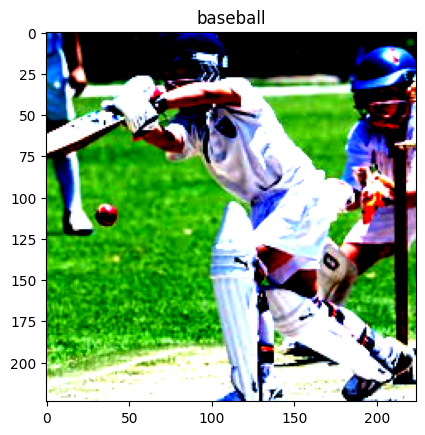

In [83]:
model.eval()
with torch.no_grad():
    image = image.to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)
    predict_class = predicted.item()
print(labels[predict_class])
img = image.to(device = 'cpu')
plt.imshow(img[0].permute(1,2,0))
plt.title(labels[predict_class])
plt.show()

# GoogLeNet (Inception v1)

In [45]:
model = models.googlenet(weights = models.GoogLeNet_Weights.DEFAULT)

## Modify Last Layers of the model

In PyTorch, the GoogLeNet model indeed does not have an attribute called classifier, unlike models such as AlexNet or VGG. Instead, GoogLeNet uses an attribute called fc for its fully connected layer, which is the final classification layer in the architecture.

In [46]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)

## Send model to device

In [47]:
model = model.to(device)

## Define Loss Function and Optimizer

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

## Train the model

In [50]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 4.284, Train_Accuracy: 12.03, Val_Loss: 3.886, Val_Accuracy: 31.6
Epoch [2/15], Train_Loss: 3.762, Train_Accuracy: 33.49, Val_Loss: 3.288, Val_Accuracy: 57.4
Epoch [3/15], Train_Loss: 3.321, Train_Accuracy: 46.26, Val_Loss: 2.788, Val_Accuracy: 65.2
Epoch [4/15], Train_Loss: 2.970, Train_Accuracy: 53.43, Val_Loss: 2.411, Val_Accuracy: 71.8
Epoch [5/15], Train_Loss: 2.696, Train_Accuracy: 57.17, Val_Loss: 2.087, Val_Accuracy: 74.4
Epoch [6/15], Train_Loss: 2.526, Train_Accuracy: 60.23, Val_Loss: 2.040, Val_Accuracy: 75.6
Epoch [7/15], Train_Loss: 2.511, Train_Accuracy: 60.85, Val_Loss: 2.039, Val_Accuracy: 74.8
Epoch [8/15], Train_Loss: 2.475, Train_Accuracy: 61.23, Val_Loss: 1.989, Val_Accuracy: 75.8
Epoch [9/15], Train_Loss: 2.456, Train_Accuracy: 61.47, Val_Loss: 1.992, Val_Accuracy: 76.2
Epoch [10/15], Train_Loss: 2.437, Train_Accuracy: 61.58, Val_Loss: 1.966, Val_Accuracy: 76.4
Epoch [11/15], Train_Loss: 2.419, Train_Accuracy: 62.11, Val_Loss: 1.936, Val_A

## Validate the model

In [51]:
validate(model, train_loader, test_loader)

Accuracy train: 0.66
Accuracy val: 0.79


{'train': 0.6617995849392232, 'val': 0.788}

## Plotting Resluts

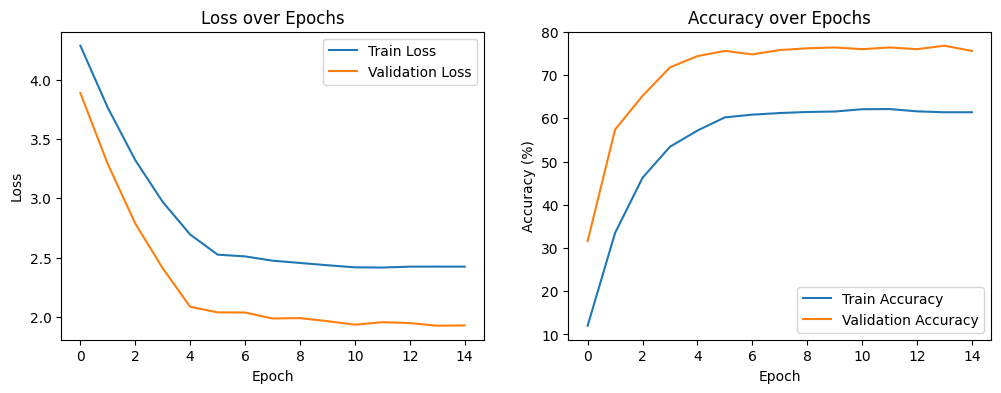

In [53]:
show_results(history)

# ResNet

## ResNet50

In [66]:
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

## Modify Last Layer

In [67]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)

## Send model to device

In [68]:
model = model.to(device)

## Define Loss Function and Optimizer

In [71]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size = 5, gamma=0.1)

# Train the Model

In [72]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 3.971, Train_Accuracy: 32.25, Val_Loss: 3.407, Val_Accuracy: 67.2
Epoch [2/15], Train_Loss: 3.243, Train_Accuracy: 59.47, Val_Loss: 2.717, Val_Accuracy: 76.8
Epoch [3/15], Train_Loss: 2.731, Train_Accuracy: 65.55, Val_Loss: 2.159, Val_Accuracy: 80.2
Epoch [4/15], Train_Loss: 2.347, Train_Accuracy: 69.74, Val_Loss: 1.802, Val_Accuracy: 84.4
Epoch [5/15], Train_Loss: 2.045, Train_Accuracy: 72.24, Val_Loss: 1.480, Val_Accuracy: 85.4
Epoch [6/15], Train_Loss: 1.904, Train_Accuracy: 73.73, Val_Loss: 1.484, Val_Accuracy: 86.2
Epoch [7/15], Train_Loss: 1.874, Train_Accuracy: 74.10, Val_Loss: 1.422, Val_Accuracy: 85.4
Epoch [8/15], Train_Loss: 1.856, Train_Accuracy: 73.14, Val_Loss: 1.417, Val_Accuracy: 87.2
Epoch [9/15], Train_Loss: 1.846, Train_Accuracy: 73.38, Val_Loss: 1.401, Val_Accuracy: 86.8
Epoch [10/15], Train_Loss: 1.817, Train_Accuracy: 73.98, Val_Loss: 1.376, Val_Accuracy: 86.6
Epoch [11/15], Train_Loss: 1.803, Train_Accuracy: 74.25, Val_Loss: 1.374, Val_A

## Validate the Model

In [73]:
validate(model, train_loader, test_loader)

Accuracy train: 0.76
Accuracy val: 0.89


{'train': 0.7587459235102283, 'val': 0.886}

## Plot Results

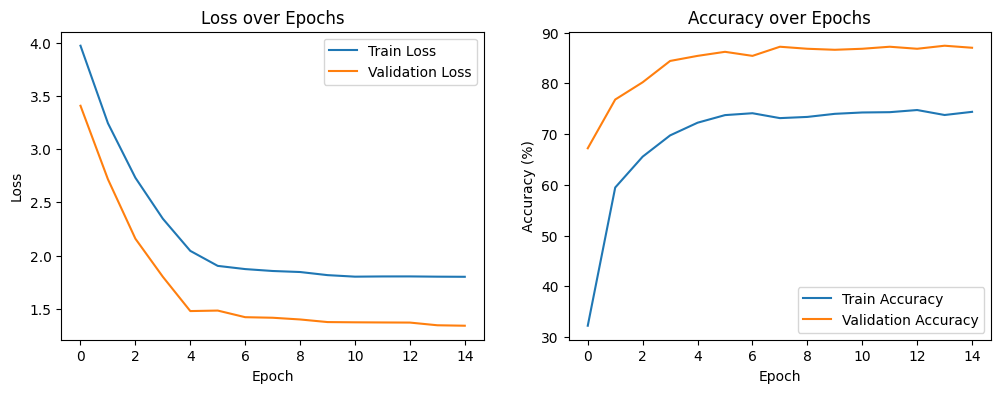

In [74]:
show_results(history)